In [11]:
# Torch
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
from torcheval.metrics import *

# Benny pointnet
from pointnet2_benny import pointnet2_cls_msg
from pointnet2_benny import provider

# Other
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter
from datetime import datetime
import pickle

# Custom modules
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.SubjectDataset import *

### Dataset hyperparameters

In [12]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-large-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the data of interest
data_string = 'hcampus_pointcloud'

# Dictionary key representing the disease labels
labels_string = 'research_group'

# Prevent class imbalance
downsample_majority = False

# NB this argument makes prevent_id_leakage redundant
single_img_per_subject = False

# Prevent the same subject id from occuring in train and test, in case of more than one image per id
prevent_id_leakage = True

batch_size = 20

test_size = 0.3

### Dataset creation

In [13]:
dataset = SubjectDataset(data_path, selected_labels, downsample_majority=downsample_majority, single_img_per_subject=single_img_per_subject)

### Data checks

Check the size of the dataset and the number of unique labels and IDs

In [ ]:
print(f"Dataset size: {len(dataset)}\n")

labels = [dataset[index]['research_group'] for index in range(len(dataset.subject_list))]

ids = [dataset.subject_list[index].subject_metadata['Subject'] for index in range(len(dataset.subject_list))]

print(f"Unique labels: {np.unique(labels, return_counts=True)}\n")

print(f"Unique ids: {np.unique(ids, return_counts=True)}\n")


Dataset size: 4569



### Loader config

In [18]:

train_data, test_data = split_dataset(dataset, test_size=test_size, prevent_id_leakage=prevent_id_leakage)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn([data_string, labels_string]))

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn([data_string, labels_string]))

['135_S_5113', '135_S_5113', '135_S_5113', '135_S_5113', '135_S_5113', '135_S_5113', '135_S_5113', '135_S_5113', '135_S_5113', '135_S_5113', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '133_S_0912', '126_S_4514', '126_S_4514', '126_S_4514', '126_S_4514', '126_S_4514', '126_S_4514', '116_S_4453', '116_S_4453', '116_S_4453', '116_S_4453', '116_S_4453', '116_S_4453', '116_S_4453', '116_S_4453', '116_S_4453', '116_S_4453', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '052_S_1251', '073_S_4552', '073_S_4552', '073_S_4552', '073_S_4552', '073_S_4552', '073_S_4552', '073_S_4552', '073_

### Data checks
Check if there are subjects split across train and test

In [ ]:

train_ids = [dataset.subject_list[index].subject_metadata['Subject'].iloc[0] for index in train_data.indices]

test_ids = [dataset.subject_list[index].subject_metadata['Subject'].iloc[0] for index in test_data.indices]

print(f"Id intersection between train and test: {np.intersect1d(np.unique(train_ids), np.unique(test_ids))}\n")

### Cuda setup

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

print(f"Using {device} device")

Notes

w/c 25/02
- Strange issue where first run (from restart) of the model gives convincing results
- After this, all epochs (even on restart) predict entirely one class and this class swaps over
- Downsampling majority class hasn't fixed this
- Could this be to do with argmax. How should I convert outputs into classes
- Could it be overfitting? Do i need more data
- After 7 epochs, got 65% accuracy with non downsampled majority, learning rate of 0.0001

w/c 3/03
- Got more data
- Adjusted sampling of both datasets to use uniform sampling at 2048 samples
- Initial dataset with new sampling results looked similar (first few epochs)
- Large dataset with new sampling results looked similar (first few epochs)
- Validation loss is much larger than training loss, could mean overfitting
- Could overfitting be to do with lack of smoothing after walking cubes?
- Training with only one image per subject gives approx 200 subjects, seems to overfit and train poorly
- Would similar images of the same subject cause overfitting or could it be considered data augmentation?


### Training hyperparameters

In [47]:
num_epochs = 200

learning_rate = 0.001

threshold = 0.5

In [ ]:

# Inplace relu from benny pointnet
def inplace_relu(m):
    
    classname = m.__class__.__name__
    
    if classname.find('ReLU') != -1:
        
        m.inplace=True

metrics = {
    "training_losses" : [],
    "validation_losses": [],
    "conf_matrices": [],
    "accuracies": [],
    "f1s": [],
    "precisions": [],
    "recalls": [],
    "train_time": None,
    "num_images": len(dataset)
}

model = pointnet2_cls_msg.get_model(dataset.num_classes, normal_channel=False)

criterion = pointnet2_cls_msg.get_loss()

# Benny inplace relu
model.apply(inplace_relu)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4, amsgrad=True)

optimizer = optim.Adam(
            model.parameters(),
            lr=0.001,
            betas=(0.9, 0.999),
            eps=1e-08,
            weight_decay=1e-4,
            amsgrad=True
        )

model.to(device)

start_time = datetime.now()

for epoch in range(num_epochs):
    
    print(f"Starting epoch {epoch + 1}\n")
    
    # Training loop
    model.train()
    
    running_loss = 0.0

    for batch_idx, dict in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        
        # Access dict returned by dataset __getitem__
        points = dict[data_string]
        labels = dict[labels_string]
        
        # Transpose as in benny script (NB why does it need a transpose)
        points = points.transpose(2, 1)
        
        points, labels = points.to(device), labels.to(device)

        # Forward pass
        output, _ = model(points)

        # Calculate loss, trans_feat argument as None as not used in this function
        loss = criterion(output, labels, None)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Multiply loss by batch size to account for differences in batch size (e.g last batch)
        running_loss += loss.item() * points.size(0)
        
    metrics['training_losses'].append(running_loss/len(train_dataloader))
    
    end_time = datetime.now()
    
    # Validation loop
    model.eval()
    
    # Initialise loop metrics
    running_loss = 0.0; conf_matrix = BinaryConfusionMatrix(); accuracy = BinaryAccuracy(); f1 = BinaryF1Score(); precision = BinaryPrecision(); recall = BinaryRecall()
    
    with torch.no_grad():
        
        for batch_idx, dict in enumerate(test_dataloader):
            
            points = dict[data_string]
            labels = dict[labels_string]
            
            points = points.transpose(2, 1)
            
            points, labels = points.to(device), labels.to(device)
            
            output, _ = model(points)
            
            running_loss += criterion(output, labels, None).item() * points.size(0)
            
            # Apply exponent as the output of the model is log softmax
            pred_probability = torch.exp(output)
            
            # Threshold is variable to give preference to FN or FP
            pred_labels = (pred_probability[:, 1] >= threshold).int()
            
            # Old label conversion
            # pred_labels = torch.argmax(pred_probability, dim=-1)

            # Update metrics
            [metric.update(pred_labels, labels) for metric in [conf_matrix, accuracy, f1, precision, recall]]

    end_time = datetime.now()
            
    # Append metric lists
    [metrics[key].append(metric.compute()) for key, metric in [("conf_matrices", conf_matrix), ("accuracies", accuracy), ("f1s", f1), ("precisions", precision), ("recalls", recall)]]       
         
    metrics['validation_losses'].append(running_loss/len(test_dataloader))
    
    print(f"\nEpoch {epoch + 1} complete\n")
    print("------------------------")
    print(conf_matrix.compute())
    print(f"Training Loss:   {metrics['training_losses'][-1]:.4f}")
    print(f"Validation Loss: {metrics['validation_losses'][-1]:.4f}")
    print(f"Accuracy:        {metrics['accuracies'][-1]:.4f}")
    print(f"F1 Score:        {metrics['f1s'][-1]:.4f}")
    print(f"Precision:       {metrics['precisions'][-1]:.4f}")
    print(f"Recall:          {metrics['recalls'][-1]:.4f}")
    print("------------------------\n\n")
        
    # Break before nightly restart
    current_time = datetime.now()
    
    if current_time.hour == 23 and current_time.minute >= 30:
        
        print("Break before nightly restart")
        
        break
    
metrics['train_time'] = end_time - start_time

torch.save(model.state_dict(), 'trained_model.pth')

print("Training complete and model saved")

### Plotting

In [16]:
# Plot training loss, validation loss, and accuracy on separate subplots, along with displaying hyperparameters
def plot(metrics, param_list, save=True):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    ax1.plot(metrics['training_losses'], label='Training Loss', color='blue')
    ax1.plot(metrics['validation_losses'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss over Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax2.plot(metrics['accuracies'], label='Accuracy', color='green')
    ax2.plot(metrics['f1s'], label='F1 Score', color='blue')
    ax2.plot(metrics['precisions'], label='Precision', color='red')
    ax2.plot(metrics['recalls'], label='Recall', color='orange')
    ax2.set_title('Metrics over epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    minutes = metrics['train_time'].seconds // 60

    seconds = metrics['train_time'].seconds % 60

    train_time_str = f"Training time: {minutes:02d}m {seconds:02d}s"

    info = []
    info.append(train_time_str)
    info.append(f"Number of images: {metrics['num_images']:.2f}")
    info.append(f"Best accuracy: {max(metrics['accuracies']):.2f}")
    info.append(f"Best F1 Score: {max(metrics['f1s']):.2f}")
    info.append(f"Best Precision: {max(metrics['precisions']):.2f}")
    info.append(f"Best Recall: {max(metrics['recalls']):.2f}")
    info.append(f"Epoch with smallest validation loss: {metrics['validation_losses'].index(min(metrics['validation_losses'])):.0f}")
    info.append("\n\n")

    for param in param_list:
        for name, value in globals().items():
            if value is param:
                info.append(f"{name}: {value}")
    
    info_text = "\n".join(info)
    
    fig.text(0.5, 0.02, info_text, ha='center', va='top', wrap=True, fontsize=10)

    if save:
        
        # Save the fig and the lists of values
        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") 
        
        name = f"plot_{current_time}"
        
        with open(f'/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/figs/{name}.pkl', 'wb') as file:
            
            pickle.dump(metrics, file)
        
        plt.savefig(f'/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/figs/{name}.png', bbox_inches='tight')
    
    plt.show()
    
    return


In [ ]:

plot(metrics, [selected_labels, data_string, labels_string, downsample_majority, single_img_per_subject, batch_size, test_size, learning_rate, num_epochs, threshold])


KeyError: 'num_images'

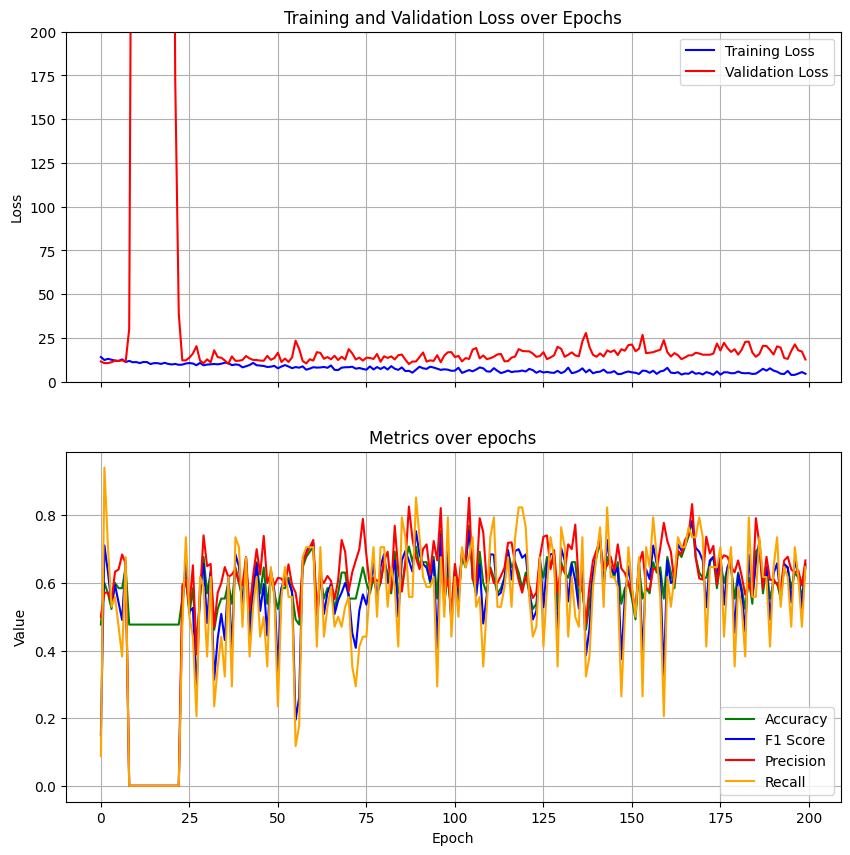

In [17]:
with open("/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/figs/plot_2025-03-05_13-39-58.pkl", 'rb') as file:
    
    metrics = pickle.load(file)
    
plot(metrics, [], save=False)
